In [1]:
from typing import Generic, TypeVar, overload, NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pygame as pg

pg.init()

pygame 2.4.0 (SDL 2.26.4, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


(5, 0)

In [2]:
Number = float
E = TypeVar("E", bound=Number)


class Vector2D(Generic[E]):
    def __init__(self, x: Number, y: Number) -> None:
        self.x = x
        self.y = y

    def __add__(self, other: "Vector2D[E]") -> "Vector2D[E]":
        return Vector2D(self.x + other.x, self.y + other.y)

    def __sub__(self, other: "Vector2D[E]") -> "Vector2D[E]":
        return Vector2D(self.x - other.x, self.y - other.y)

    def __mul__(self, other: E | "Vector2D[E]") -> "Vector2D[E]":
        if isinstance(other, Vector2D):
            return Vector2D(self.x * other.x, self.y * other.y)
        return Vector2D(self.x * other, self.y * other)

    def __matmul__(self, other: "Vector2D[E]") -> E:
        return self.x * other.x + self.y * other.y  # type: ignore

    def dot(self, other: "Vector2D[E]") -> E:
        return self @ other

    def __abs__(self) -> E:
        return (self.x ** 2 + self.y ** 2) ** 0.5

    def __neg__(self) -> "Vector2D[E]":
        return Vector2D(-self.x, -self.y)

    def __repr__(self) -> str:
        return f"Vector2D({self.x}, {self.y})"

    def __len__(self) -> int:
        return 2

    def __getitem__(self, index: int) -> E:
        return (self.x, self.y)[index]  # type: ignore

    def __iter__(self):
        yield self.x
        yield self.y

    def draw_point(self, ax=None, **kwargs) -> None:
        ax = ax or plt.gca()
        ax.scatter(self[0], self[1], **dict(color="red", s=1) | kwargs)

    def draw(self, pos: "Vector2D[E]", ax=None, **kwargs) -> None:
        ax = ax or plt.gca()
        ax.arrow(
            pos[0],
            pos[1],
            self[0],
            self[1],
            **dict(
                head_width=0.5,
                head_length=0.5,
                fc="slategray",
                ec="slategray",
            ) | kwargs
        )


class Rect:
    def __init__(self, x: Number, y: Number, w: Number, h: Number) -> None:
        self.x = x
        self.y = y
        self.w = w
        self.h = h

    @property
    def center(self) -> Vector2D:
        return Vector2D(self.x + self.w / 2, self.y + self.h / 2)

    @property
    def centerx(self) -> Number:
        return self.x + self.w / 2

    @property
    def centery(self) -> Number:
        return self.y + self.h / 2

    @property
    def left(self) -> Number:
        return self.x

    @property
    def right(self) -> Number:
        return self.x + self.w

    @property
    def top(self) -> Number:
        return self.y

    @property
    def bottom(self) -> Number:
        return self.y + self.h

    def collide(self, other: "Rect") -> bool:
        return (
                self.x < other.x + other.w
                and self.x + self.w > other.x
                and self.y < other.y + other.h
                and self.y + self.h > other.y
        )

    def clip(self, other: "Rect") -> "Rect":
        x = max(self.x, other.x)
        y = max(self.y, other.y)
        w = min(self.x + self.w, other.x + other.w) - x
        h = min(self.y + self.h, other.y + other.h) - y
        return Rect(x, y, w, h)

    def draw(self, **kwargs) -> None:
        plt.gca().add_patch(
            plt.Rectangle(
                (self.x, self.y),
                self.w,
                self.h,
                **dict(
                    linewidth=1,
                    edgecolor="black",
                    facecolor="none",
                ) | kwargs
            )
        )

    @overload
    def move(self, x: Number, y: Number) -> "Rect":
        ...

    @overload
    def move(self, x: Vector2D, y: None = None) -> "Rect":
        ...

    def move(self, x, y=None):
        if isinstance(x, Vector2D):
            x, y = x
        x = self.x + x
        y = self.y + y  # type: ignore
        return Rect(x, y, self.w, self.h)

In [3]:
class RigidBody:
    def __init__(
            self,
            rect: Rect,
            pos: Vector2D = Vector2D(0, 0),
            vel: Vector2D = Vector2D(0, 0),
            acc: Vector2D = Vector2D(0, 0),
            mass: Number = 1,
    ) -> None:
        self.rect = rect
        self.pos = pos
        self.vel = vel
        self.acc = acc
        self.mass = mass

    def move(self, vec: Vector2D) -> None:
        self.pos += vec

    def update(self, dt: Number) -> None:
        self.vel += self.acc * dt
        self.pos += self.vel * dt

    def draw(self, ax=None) -> None:
        ax = ax or plt.gca()
        self.pos.draw_point(ax=ax)
        self.vel.draw(self.pos, ax=ax)
        self.acc.draw(self.pos, ax=ax)

    def __repr__(self) -> str:
        return (
            f"RigidBody({self.rect}, {self.pos}, {self.vel}, {self.acc}, {self.mass})"
        )

In [50]:
class ContactResult(NamedTuple):
    point: Vector2D
    normal: Vector2D
    plane: Vector2D
    penetration_depth: float
    time_of_contact: float


def calculate_contact(
        a: Rect,
        b: Rect,
        v_a: Vector2D,
        v_b: Vector2D,
) -> ContactResult:
    try:
        t_x_enter = (b.left - a.right) / (v_a[0] - v_b[0])
        t_x_exit = (b.right - a.left) / (v_a[0] - v_b[0])
        t_y_enter = (b.top - a.bottom) / (v_a[1] - v_b[1])
        t_y_exit = (b.bottom - a.top) / (v_a[1] - v_b[1])
    except ZeroDivisionError:
        raise ValueError("No collision")

    t_contact = max(min(t_x_enter, t_x_exit), min(t_y_enter, t_y_exit))
    t_exit = min(max(t_x_enter, t_x_exit), max(t_y_enter, t_y_exit))

    if t_contact > t_exit or t_exit < 0:
        raise ValueError("No collision")

    penetration = min(
        a.right - b.left,
        b.right - a.left,
        a.bottom - b.top,
        b.bottom - a.top,
    )

    a = a.move(v_a * t_contact)
    b = b.move(v_b * t_contact)
    xs = sorted([a.left, a.right, b.left, b.right])[1:3]
    ys = sorted([a.top, a.bottom, b.top, b.bottom])[1:3]
    contact = Vector2D((xs[0] + xs[1]) / 2, (ys[0] + ys[1]) / 2)

    normal = Vector2D(
        1 if contact[0] == a.left else -1 if contact[0] == a.right else 0,
        1 if contact[1] == a.top else -1 if contact[1] == a.bottom else 0,
    )
    plane = Vector2D(
        -normal[1],
        normal[0],
    )

    return ContactResult(contact, normal, plane, penetration, t_contact)

In [51]:
def test_collision(a: Rect, b: Rect, v_a: Vector2D, v_b: Vector2D) -> None:
    fig, ax = plt.subplots()

    min_x = min(a.x, b.x)
    min_y = min(a.y, b.y)
    max_x = max(a.x + a.w, b.x + b.w)
    max_y = max(a.y + a.h, b.y + b.h)
    ax.set_xlim(min_x - 5, max_x + 5)
    ax.set_ylim(min_y - 5, max_y + 5)
    ax.invert_yaxis()

    ax.set_aspect("equal")
    v_a.draw(a.center), v_b.draw(b.center)

    a.draw(ec="brown"), b.draw(ec="orange")
    result = contact_point, normal, plane, penetration, t_contact = calculate_contact(a, b, v_a, v_b)
    # print(result)
    a.move(v_a * t_contact).draw(ec="gray", ls="--")
    b.move(v_b * t_contact).draw(ec="gray", ls="--")

    contact_point.draw_point(ec="orangered", fc="orangered", s=4)
    normal.draw(contact_point, ec="orangered", fc="orangered")
    plane.draw(contact_point, ec="orangered", fc="orangered")

    return result

ContactResult(point=Vector2D(7.5, 7.0), normal=Vector2D(0, 1), plane=Vector2D(-1, 0), penetration_depth=-2, time_of_contact=2.0)

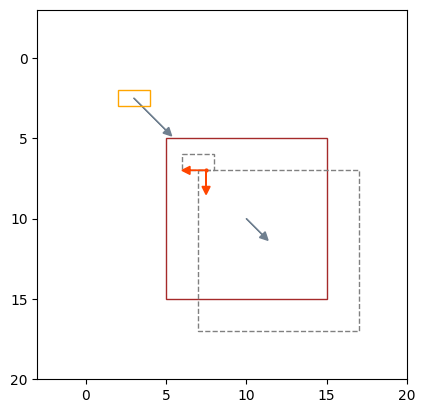

In [52]:
a = Rect(5, 5, 10, 10)
b = Rect(2, 2, 2, 1)
v_a = Vector2D(1, 1)
v_b = Vector2D(2, 2)
test_collision(a, b, v_a, v_b)

ContactResult(point=Vector2D(2.0, 2.0), normal=Vector2D(1, 1), plane=Vector2D(-1, 1), penetration_depth=1, time_of_contact=-1.0)

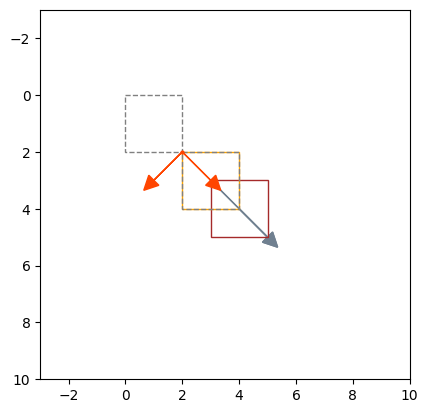

In [53]:
a = Rect(3, 3, 2, 2)
b = Rect(2, 2, 2, 2)
v_a = Vector2D(1, 1)
v_b = Vector2D(2, 2)
test_collision(a, b, v_a, v_b)

ContactResult(point=Vector2D(3.5, 4.75), normal=Vector2D(1, 0), plane=Vector2D(0, 1), penetration_depth=-1, time_of_contact=0.5)

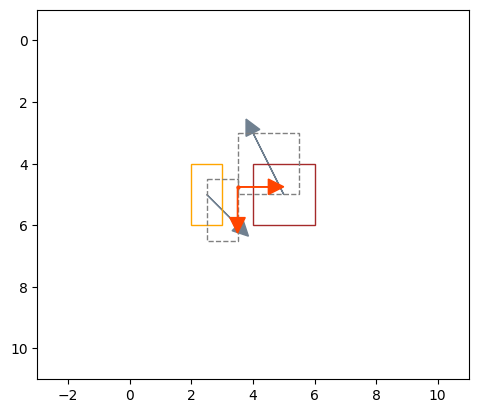

In [54]:
a = Rect(4, 4, 2, 2)
b = Rect(2, 4, 1, 2)
v_a = Vector2D(-1, -2)
v_b = Vector2D(1, 1)
test_collision(a, b, v_a, v_b)